## Data Loading

In [194]:
from scipy import io
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

filename = '../../data/LRHandMI/s01.mat'

mat_file = scipy.io.loadmat(filename)
print(mat_file.keys())

dict_keys(['__header__', '__version__', '__globals__', 'eeg'])


In [195]:
# 'eeg' 구조체 추출
eeg = mat_file['eeg']

# 필드 추출
noise = eeg['noise'][0, 0]
rest = eeg['rest'][0, 0]
srate = eeg['srate'][0, 0][0, 0]  # 배열에서 스칼라 값 추출
movement_left = eeg['movement_left'][0, 0]
movement_right = eeg['movement_right'][0, 0]
movement_event = eeg['movement_event'][0, 0][0]
n_movement_trials = eeg['n_movement_trials'][0, 0][0, 0]
imagery_left = eeg['imagery_left'][0, 0]
imagery_right = eeg['imagery_right'][0, 0]
n_imagery_trials = eeg['n_imagery_trials'][0, 0][0, 0]
frame = eeg['frame'][0, 0][0]
imagery_event = eeg['imagery_event'][0, 0][0]
comment = eeg['comment'][0, 0]
subject = eeg['subject'][0, 0]
bad_trial_indices = eeg['bad_trial_indices'][0, 0]
psenloc = eeg['psenloc'][0, 0]
senloc = eeg['senloc'][0, 0]

# 데이터 형태 확인
print("Noise:", noise.shape)
print("Rest shape:", rest.shape)
print("Sampling Rate:", srate)
print("Movement Left shape:", movement_left.shape)
print("Movement Right shape:", movement_right.shape)
print("Movement Event:", movement_event)
print("Number of Movement Trials:", n_movement_trials)
print("Imagery Left shape:", imagery_left.shape)
print("Imagery Right shape:", imagery_right.shape)
print("Number of Imagery Trials:", n_imagery_trials)
print("Frame:", frame)
print("Imagery Event:", imagery_event)
print("Comment:", comment)
print("Subject:", subject)
print("Bad Trial Indices:", bad_trial_indices.shape)
print("PSenloc:", psenloc.shape)
print("Senloc:", senloc.shape)

Noise: (5, 1)
Rest shape: (68, 34048)
Sampling Rate: 512
Movement Left shape: (68, 71680)
Movement Right shape: (68, 71680)
Movement Event: [0 0 0 ... 0 0 0]
Number of Movement Trials: 20
Imagery Left shape: (68, 358400)
Imagery Right shape: (68, 358400)
Number of Imagery Trials: 100
Frame: [-2000  5000]
Imagery Event: [0 0 0 ... 0 0 0]
Comment: ['bci2011v1 left/right motor imagery']
Subject: ['subject 1']
Bad Trial Indices: (1, 1)
PSenloc: (64, 3)
Senloc: (64, 3)


In [196]:
# 채널 분리 (1~64은 EEG, 65~68은 EMG)
def split_eeg_emg(data) :
    return data[:64, :], data[64:, :]

movement_left_eeg, movement_left_emg = split_eeg_emg(movement_left)
movement_right_eeg, movement_right_emg = split_eeg_emg(movement_right)

imagery_left_eeg, imagery_left_emg = split_eeg_emg(imagery_left)
imagery_right_eeg, imagery_right_emg = split_eeg_emg(imagery_right)

rest_eeg, rest_emg = split_eeg_emg(rest)

# 데이터 확인
print(f'Movement Left EEG Shape: {movement_left_eeg.shape}')
print(f'Movement Left EMG Shape: {movement_left_emg.shape}')
print(f'Imagery Left EEG Shape: {imagery_left_eeg.shape}')
print(f'Imagery Left EMG Shape: {imagery_left_emg.shape}')
print(f'Imagery Right EEG Shape: {imagery_right_eeg.shape}')
print(f'Imagery Right EMG Shape: {imagery_right_emg.shape}')

Movement Left EEG Shape: (64, 71680)
Movement Left EMG Shape: (4, 71680)
Imagery Left EEG Shape: (64, 358400)
Imagery Left EMG Shape: (4, 358400)
Imagery Right EEG Shape: (64, 358400)
Imagery Right EMG Shape: (4, 358400)


In [197]:
# trial 분리
def split_trial(data, event, pre_event_samples, post_event_samples):
    splited_data = []
    len_data = len(event)
    for i in range(len_data):
        if event[i] == 1:
            start_idx = i - pre_event_samples
            if start_idx < 0:
                continue
            end_idx = i + post_event_samples
            if end_idx > len_data:
                continue
            splited_data.append(data[:, start_idx:end_idx])

    return np.array(splited_data)

In [266]:
pre_event_samples = int(abs(frame[0]) * srate / 1000) - 1 # -2000ms -> 2000 프레임
post_event_samples = int(frame[1] * srate / 1000)  # 5000ms -> 5000 프레임
total_samples = pre_event_samples + post_event_samples  # 총 7000 프레임

splited_movement_left_eeg = split_trial(movement_left_eeg, movement_event, pre_event_samples, post_event_samples)
splited_movement_right_eeg = split_trial(movement_right_eeg, movement_event, pre_event_samples, post_event_samples)
splited_imagery_left_eeg = split_trial(imagery_left_eeg, imagery_event, pre_event_samples, post_event_samples)
splited_imagery_right_eeg = split_trial(imagery_right_eeg, imagery_event, pre_event_samples, post_event_samples)
splited_imagery_left_eeg = split_trial(imagery_left_eeg, imagery_event, pre_event_samples, post_event_samples)

print("Movement data shape ", splited_movement_left_eeg.shape)
print("Imagery data shape: ", splited_imagery_left_eeg.shape)

Movement data shape  (20, 64, 3583)
Imagery data shape:  (100, 64, 3583)


데이터는 EEG 64채널, EMG 4채널로 이루어져 있고, imagery 100 or 120개의 Trial이 있습니다.

1초에 514개의 data point가 있고, -2초 ~ +5초 사이의 데이터입니다.


뇌파가 어떻게 생겼는지 보기 위한 함수를 만들어줍니다.

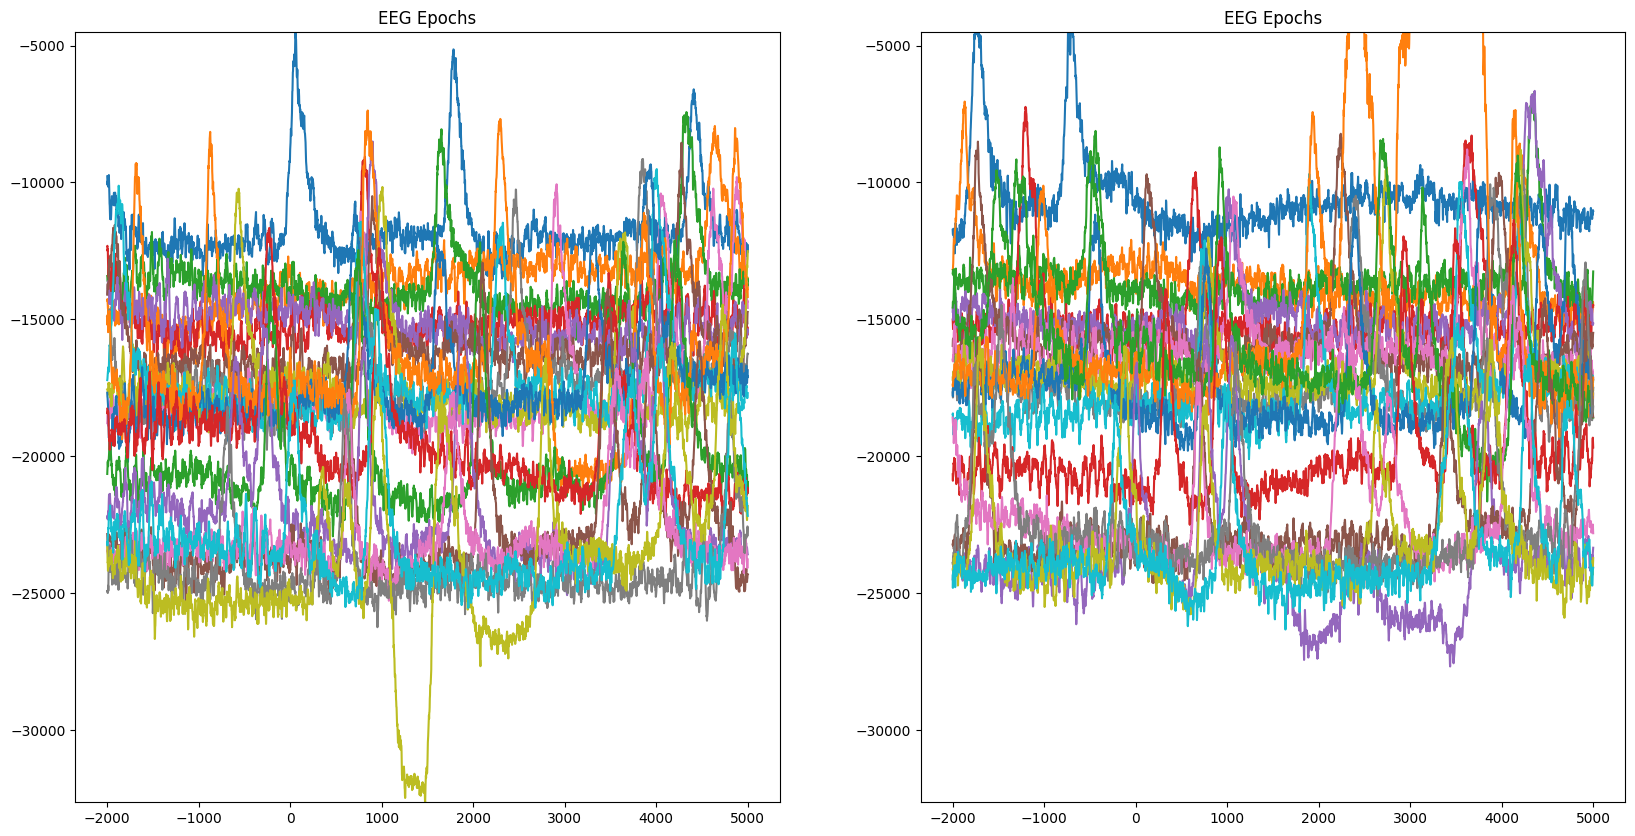

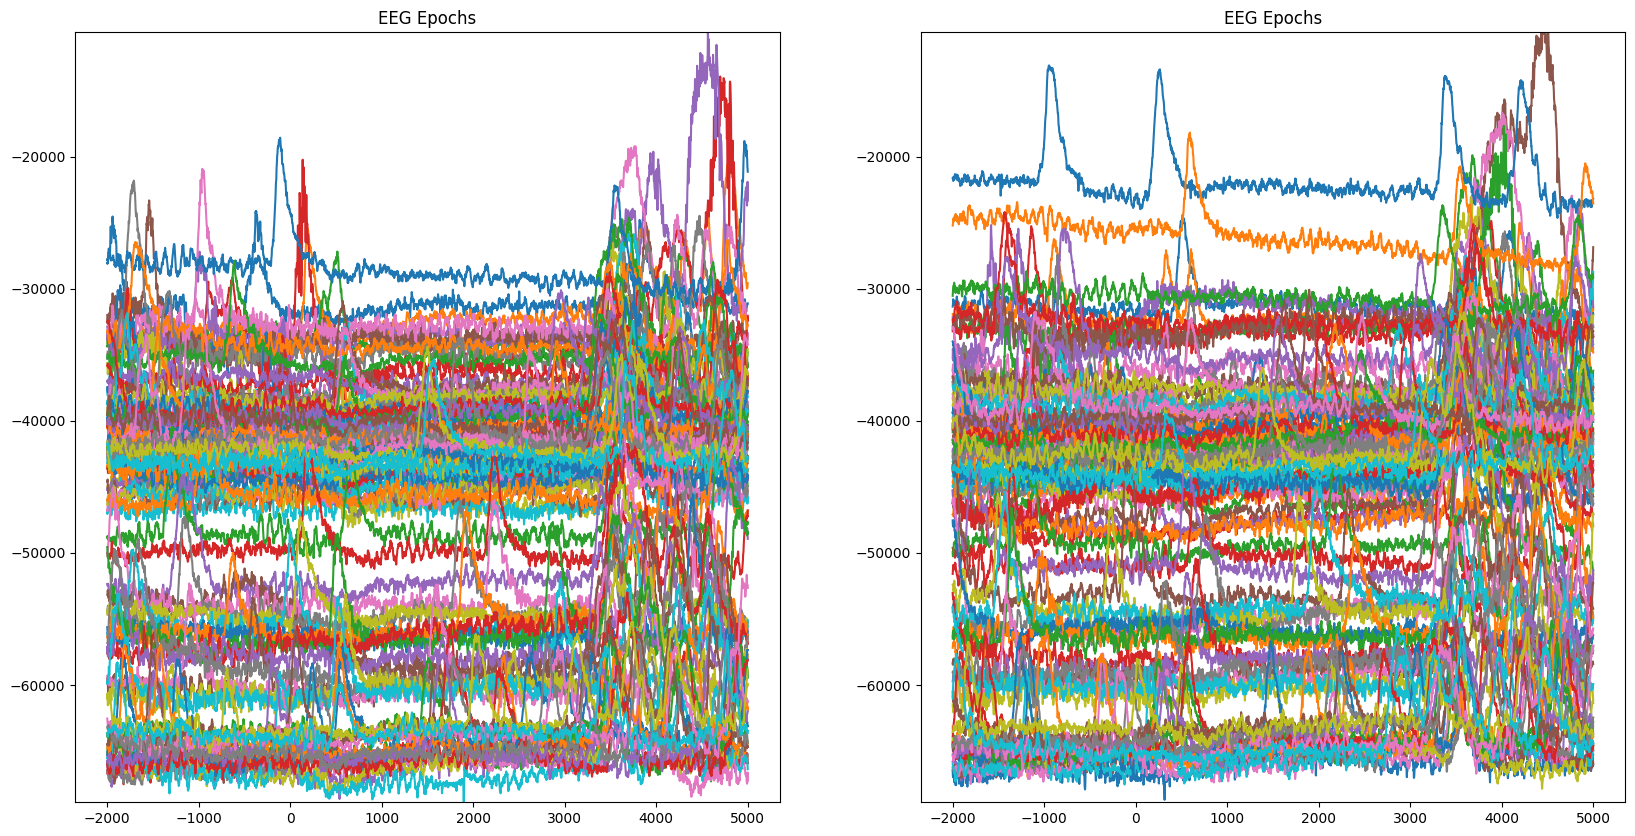

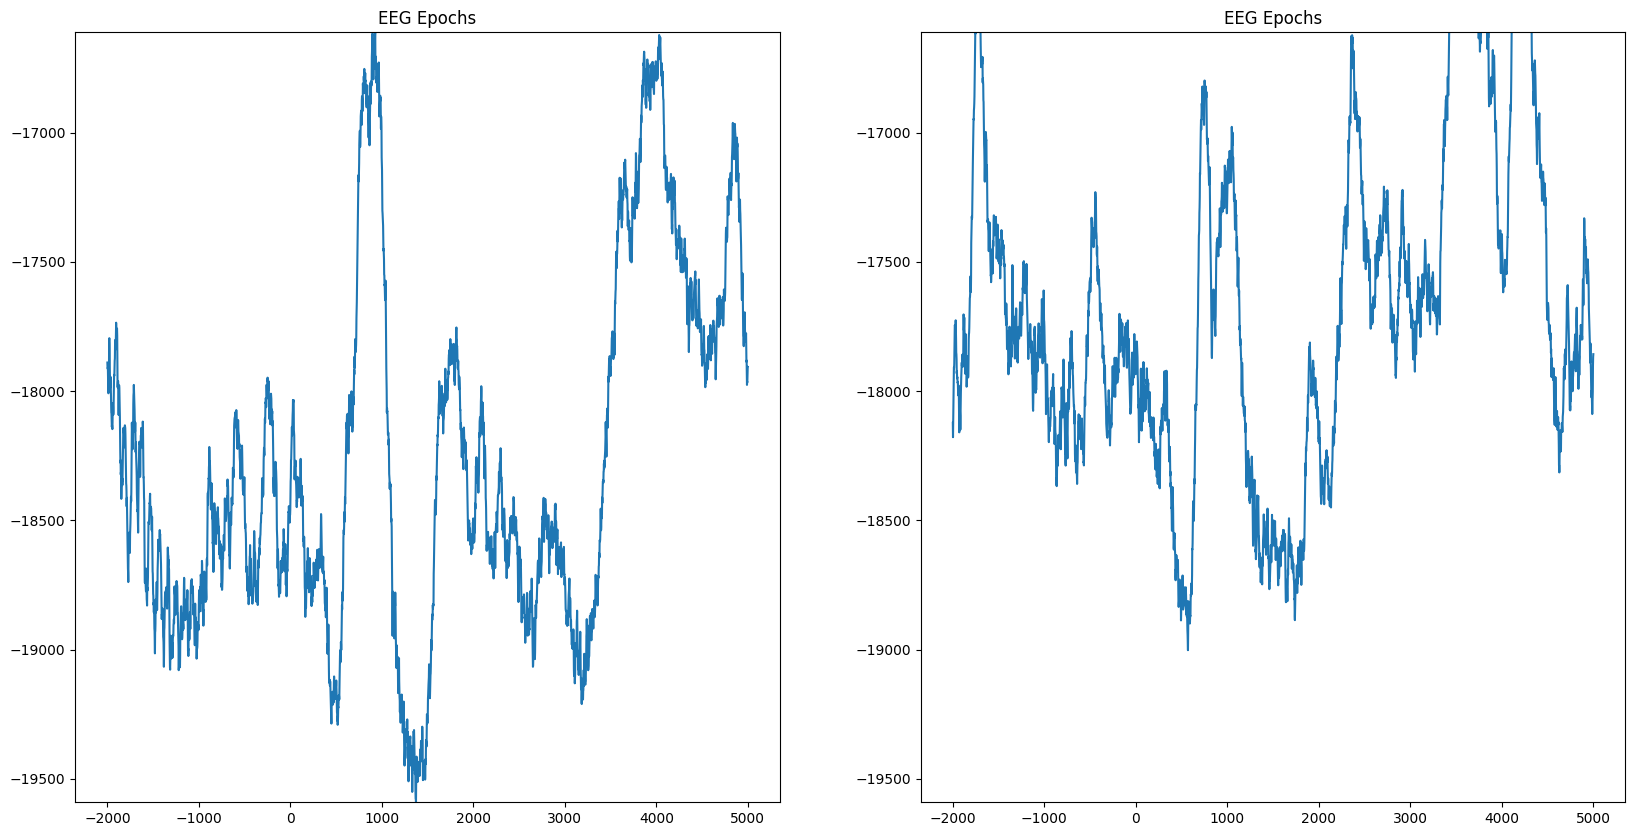

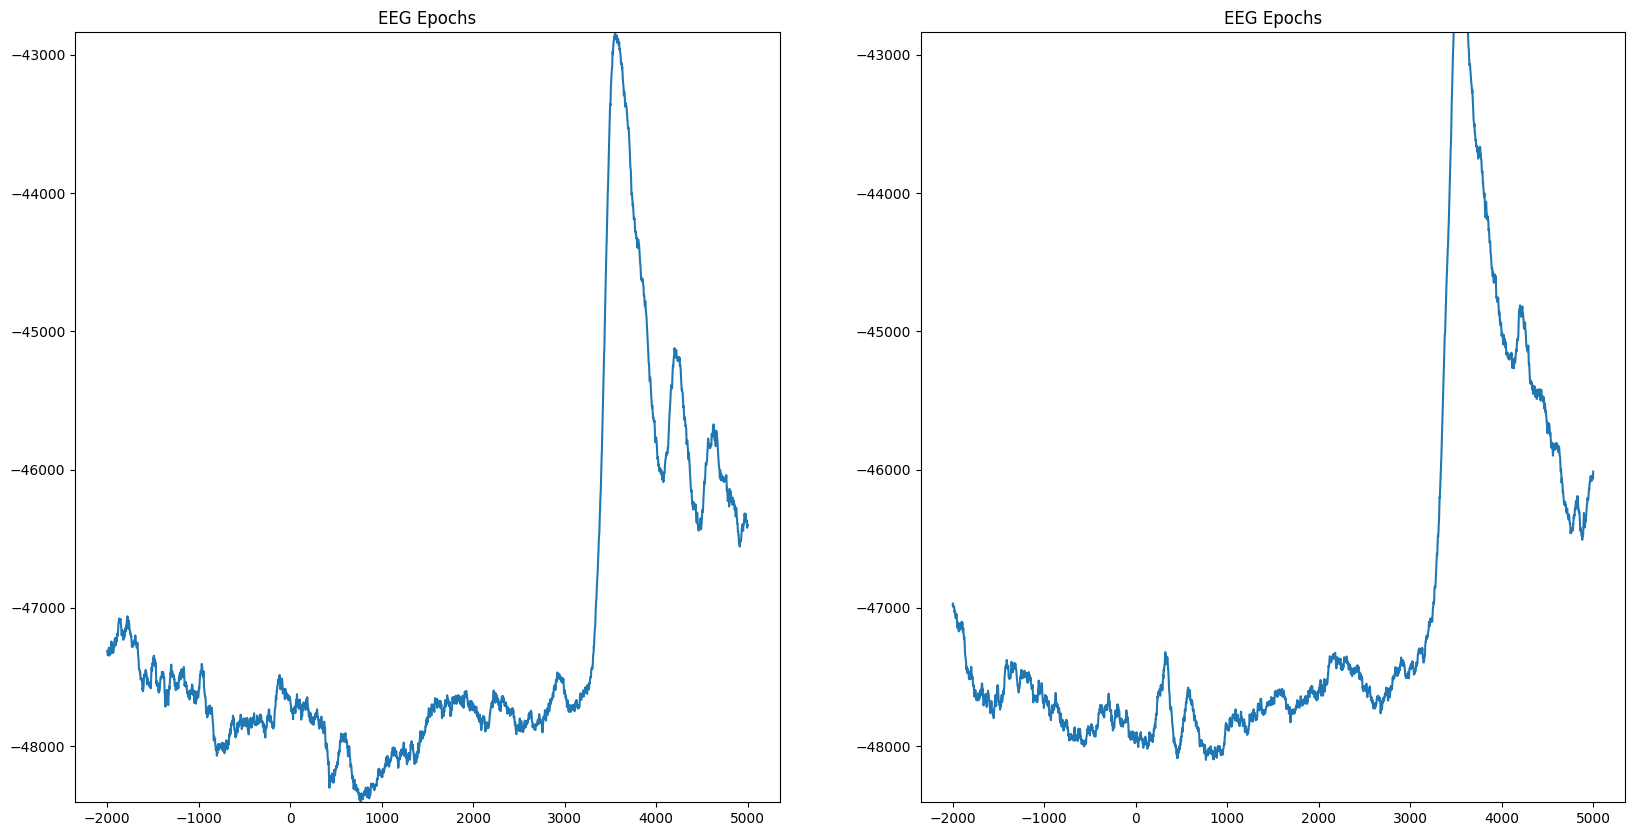

In [285]:
def draw_EEG_epochs(data1, data2, channel, is_mean=False):
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    xticks = np.linspace(-2000, 5000, data1.shape[2])  # 시간축 설정
    plotted_data1 = []
    plotted_data2 = []
    
    if is_mean:
        plotted_data1 = np.mean(data1[:, channel, :], axis=0)
        ax1.plot(xticks, plotted_data1)
        plotted_data2 = np.mean(data2[:, channel, :], axis=0)
        ax2.plot(xticks, plotted_data2)
    else:
        for epoch in data1:
            ax1.plot(xticks, epoch[channel, :])
        for epoch in data2:
            ax2.plot(xticks, epoch[channel, :])

    ylim = (np.min(plotted_data1) - 1, np.max(plotted_data1) + 1) if is_mean else (
        np.min(data1[:, channel, :]) - 1, np.max(data1[:, channel, :]) + 1)
    ax1.set_title('EEG Epochs')
    ax1.set_xticks(np.linspace(-2000, 5000, 8))
    ax1.set_ylim(ylim)
    ax2.set_title('EEG Epochs')
    ax2.set_xticks(np.linspace(-2000, 5000, 8))
    ax2.set_ylim(ylim)

    plt.show()

# 예제 사용
channel = 0  # 사용할 채널 인덱스 설정
draw_EEG_epochs(splited_movement_left_eeg, splited_movement_right_eeg, channel, is_mean=False)
draw_EEG_epochs(splited_imagery_left_eeg, splited_imagery_right_eeg, channel, is_mean=False)
for i in range(1):
    draw_EEG_epochs(splited_movement_left_eeg, splited_movement_right_eeg, channel, is_mean=True)
    draw_EEG_epochs(splited_imagery_left_eeg, splited_imagery_right_eeg, channel, is_mean=True)
    

## Preprocessing

**CAR**

Axis 1번(Channel axis)의 평균을 모든 신호에 대해서 제거합니다. 움직임이나 심장 박동 등 모든 채널에서 공통된 잡신호가 제거됩니다.

(100, 64, 3583)


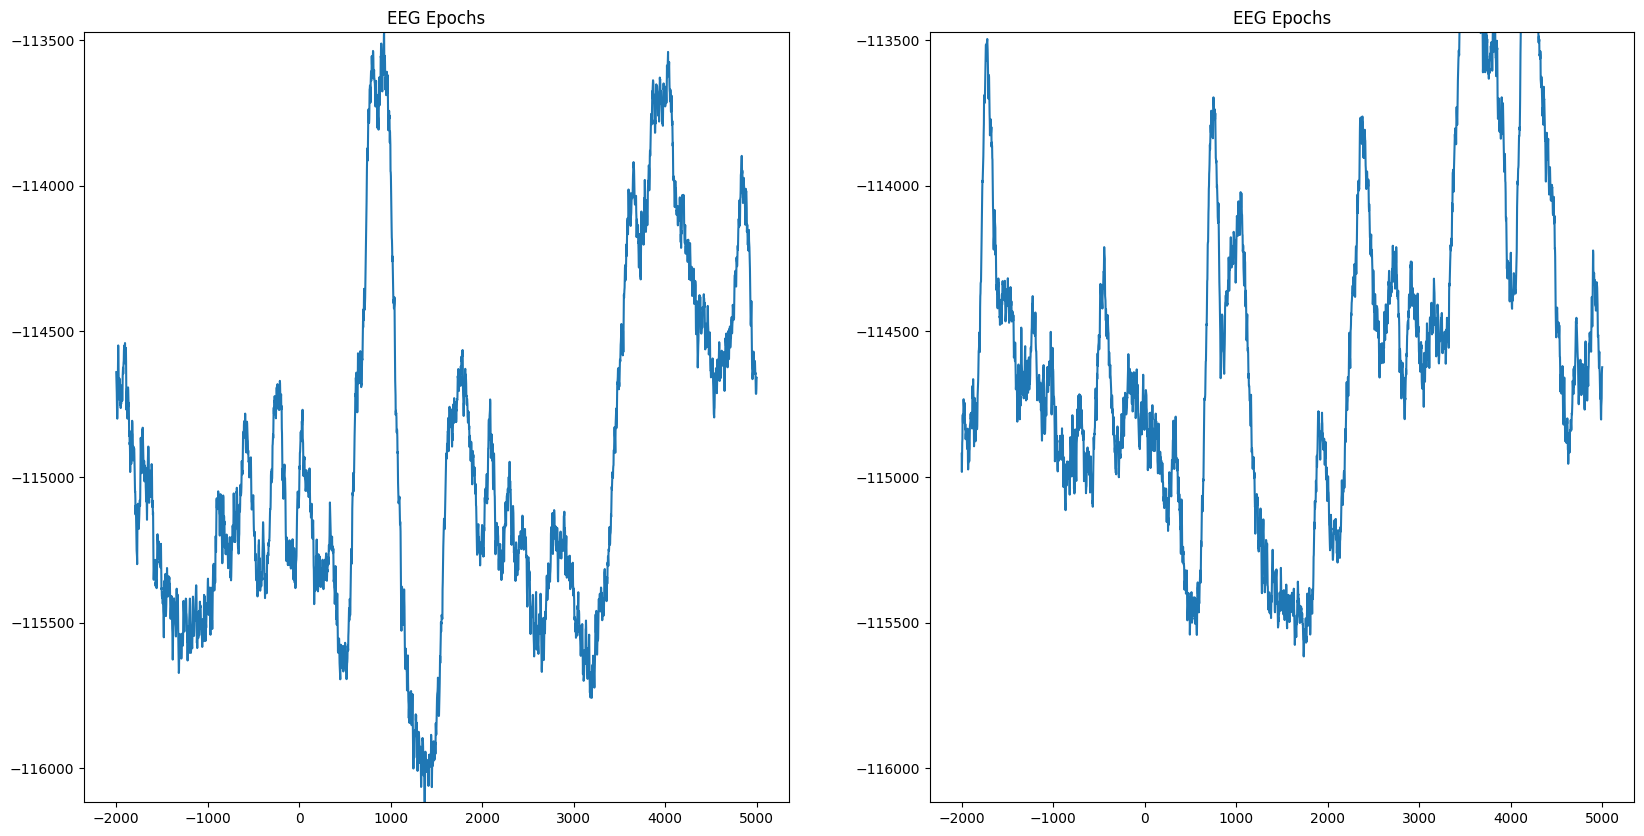

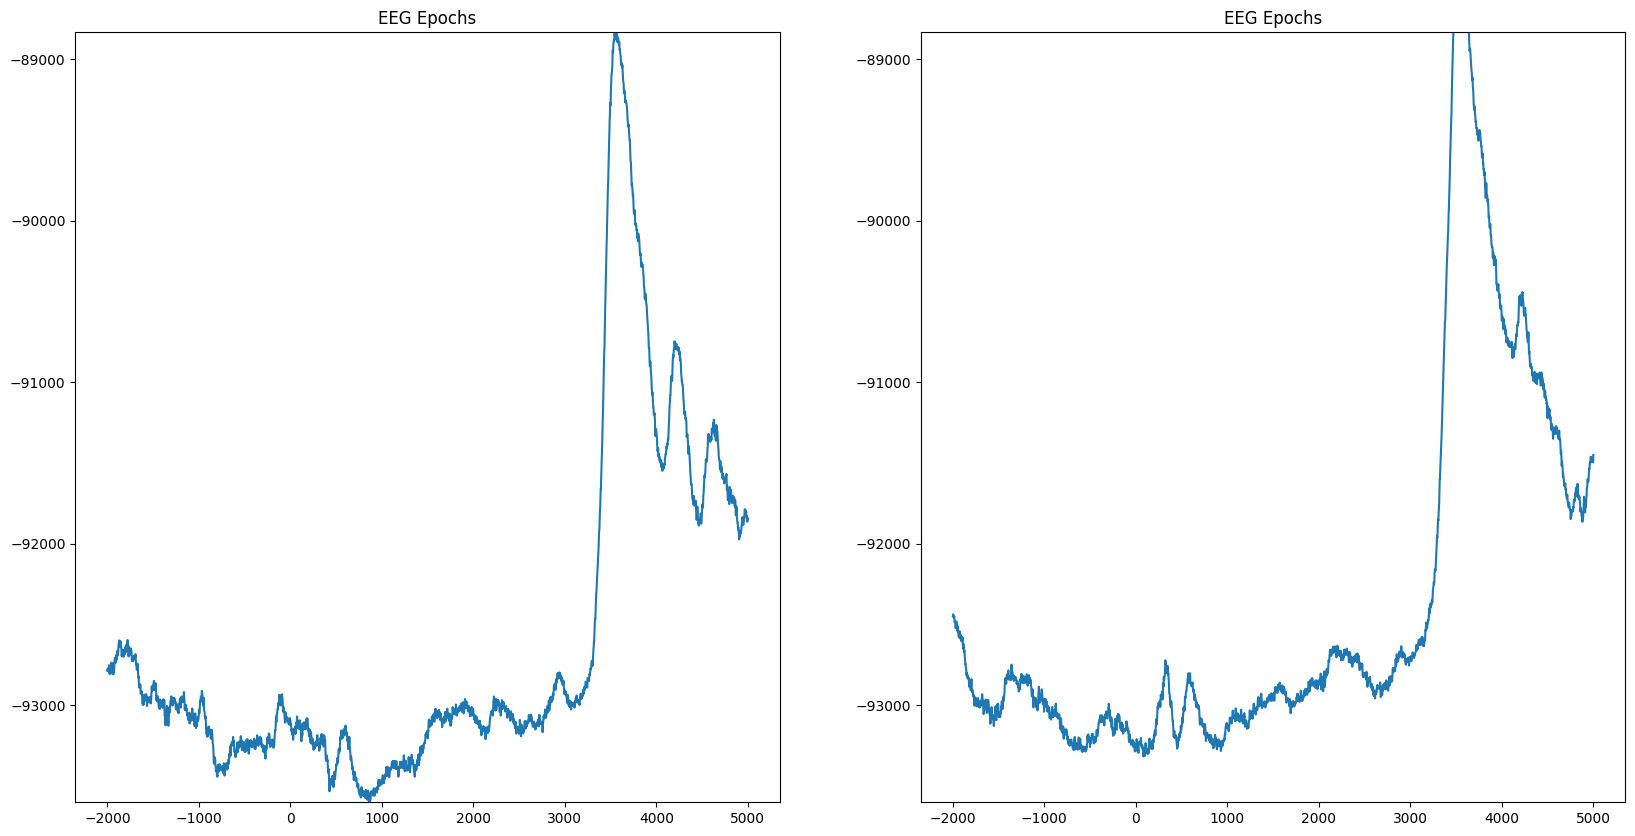

In [289]:
def apply_car(data):
    """
    Apply Common Average Reference (CAR) to EEG data.
    
    Parameters:
    data (numpy.ndarray): EEG data of shape (n_channels, n_samples)
    
    Returns:
    numpy.ndarray: CAR applied EEG data of shape (n_channels, n_samples)
    """
    # Calculate the average signal across all channels
    mean_signal = np.mean(data, axis=1, keepdims=True)

    # Subtract the average signal from each channel
    car_data = data - mean_signal
    
    return car_data


# CAR 및 Baseline Correction 적용
car_movement_left_eeg = apply_car(splited_movement_left_eeg)
car_movement_right_eeg = apply_car(splited_movement_right_eeg)
car_imagery_left_eeg = apply_car(splited_imagery_left_eeg)
car_imagery_right_eeg = apply_car(splited_imagery_right_eeg)

print(car_imagery_left_eeg.shape)
draw_EEG_epochs(car_movement_left_eeg, car_movement_right_eeg, 0, is_mean=True)
draw_EEG_epochs(car_imagery_left_eeg, car_imagery_right_eeg, 0, is_mean=True)


**Baseline Correction**

각 채널별로 -2s ~ 0s의 평균을 모든 신호에 대해 빼줍니다. 신호를 0V 기준으로 정렬하게 됩니다.

(100, 64, 3583)


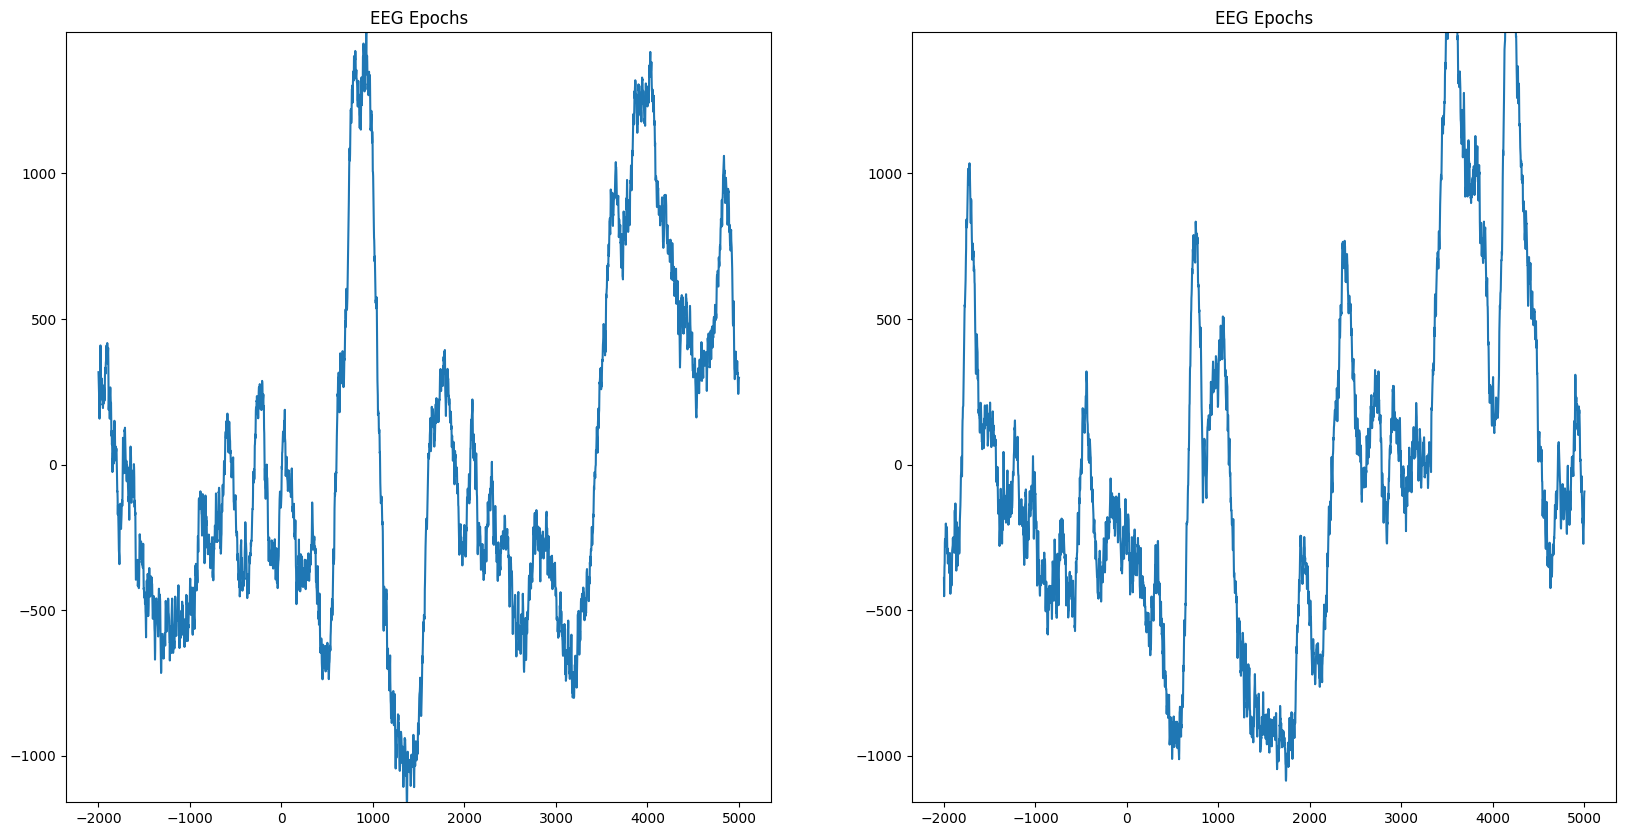

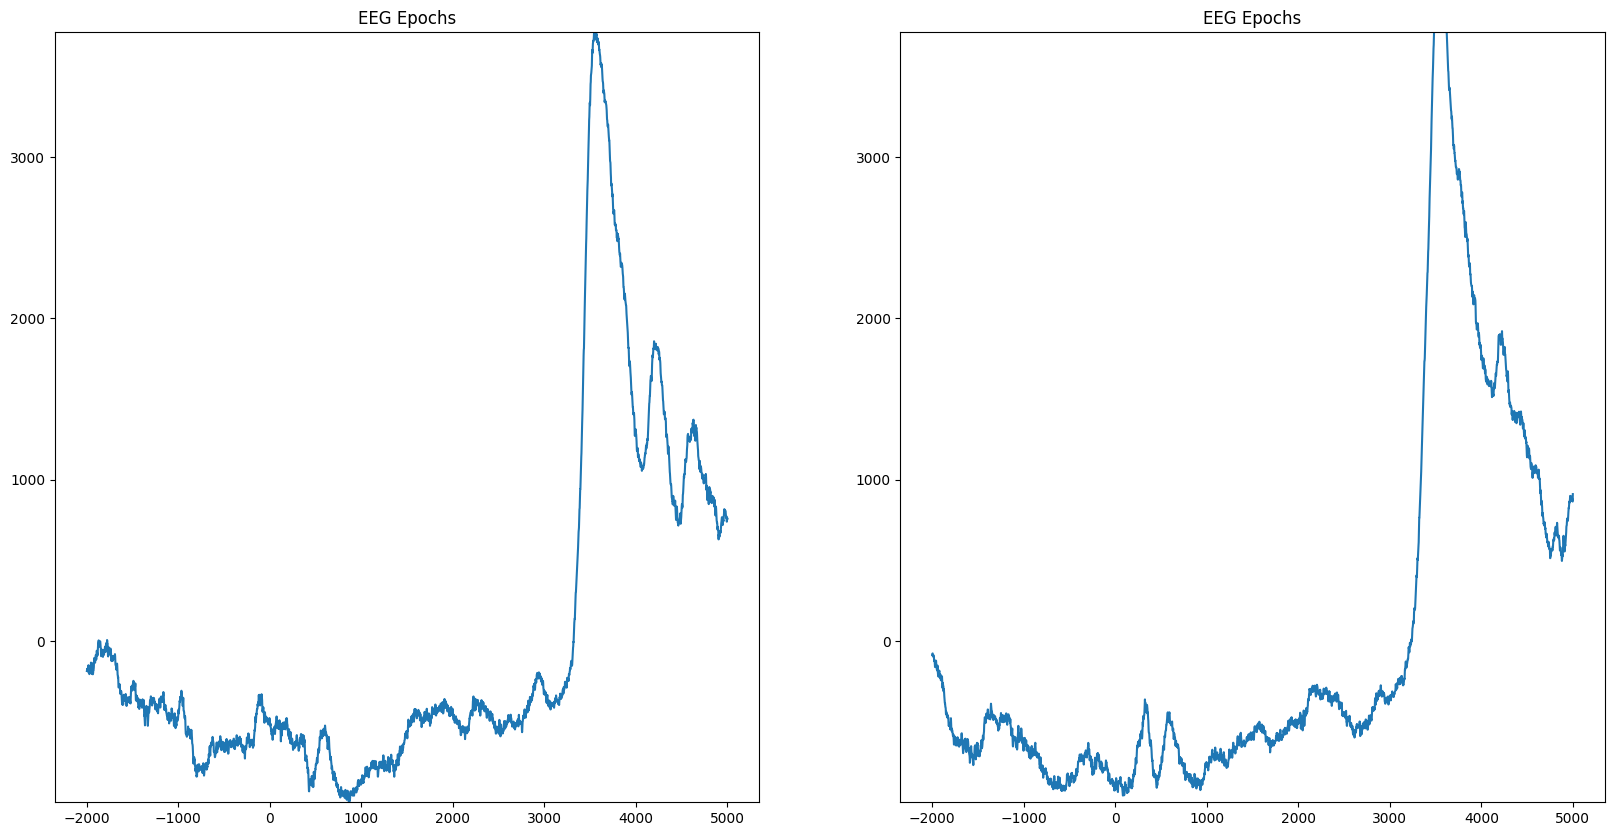

In [290]:
def baseline_correction(data, srate):
    """
    Apply baseline correction to EEG data.
    
    Parameters:
    data (numpy.ndarray): EEG data of shape (n_channels, n_samples)
    srate (float): Sampling rate (samples per second)
    pre_event_samples (int): Number of samples before the event
    
    Returns:
    numpy.ndarray: Baseline corrected EEG data of shape (n_channels, n_samples)
    """
    baseline_start_idx =  0
    baseline_end_idx = int(2 * srate) - 1
    
    baseline_mean = np.mean(data[:, baseline_start_idx:baseline_end_idx], axis=2, keepdims=True)
    
    corrected_data = data - baseline_mean

    return corrected_data

corrected_movement_left = baseline_correction(car_movement_left_eeg, srate)
corrected_movement_right = baseline_correction(car_movement_right_eeg, srate)
corrected_MI_left = baseline_correction(car_imagery_left_eeg, srate)
corrected_MI_right = baseline_correction(car_imagery_right_eeg, srate)

print(corrected_MI_left.shape)
draw_EEG_epochs(corrected_movement_left, corrected_movement_right, 0, is_mean=True)
draw_EEG_epochs(corrected_MI_left, corrected_MI_right, 0, is_mean=True)


**Bandpass Filtering** (1 ~ 30 Hz)

P300을 관측하기 위해 1 ~ 30Hz의 신호만을 추출합니다.

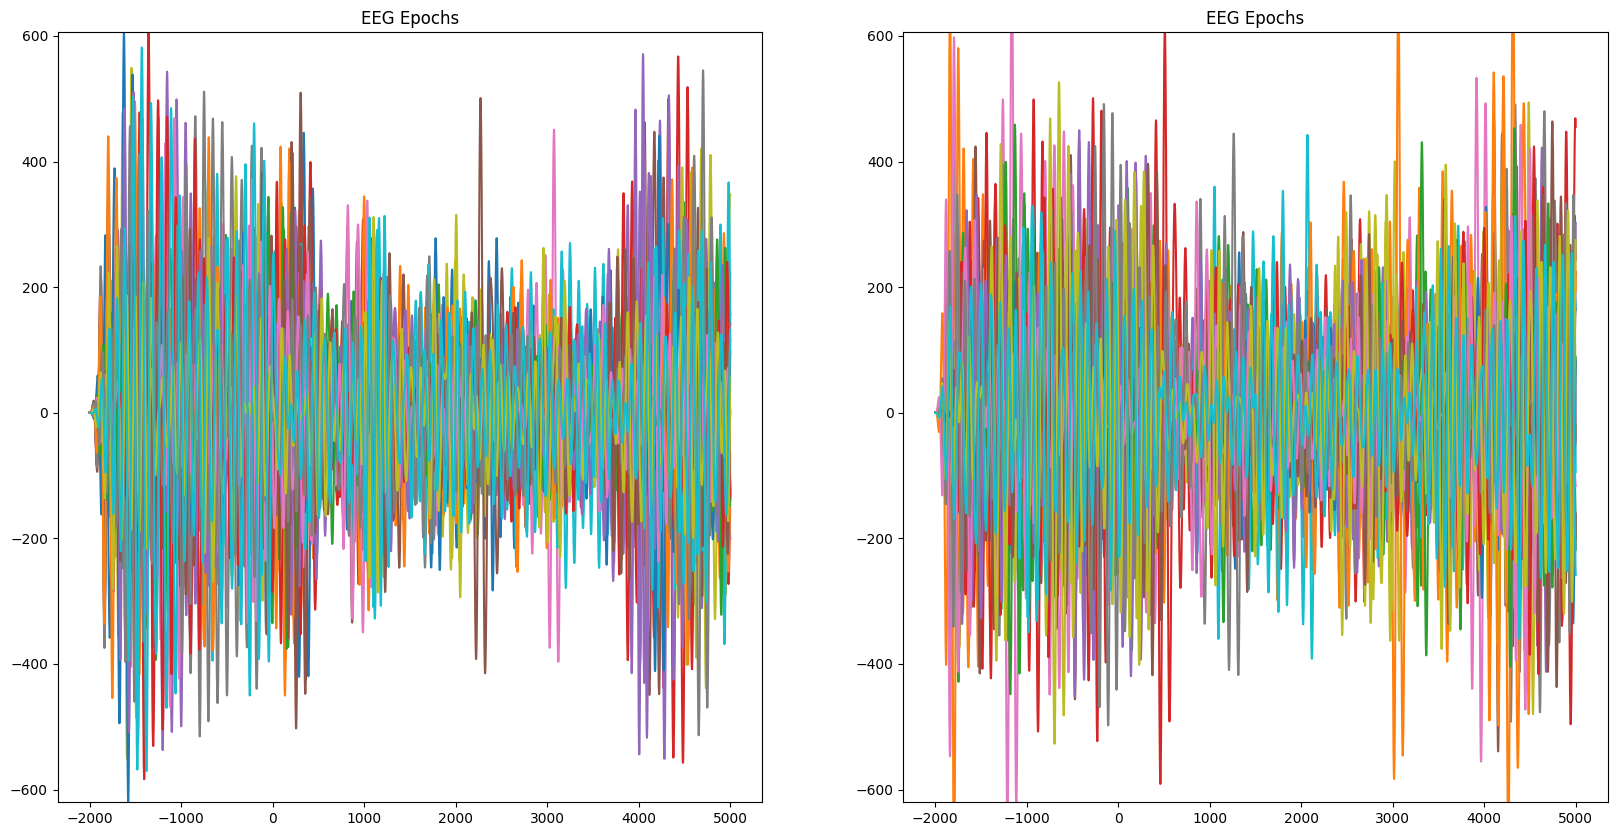

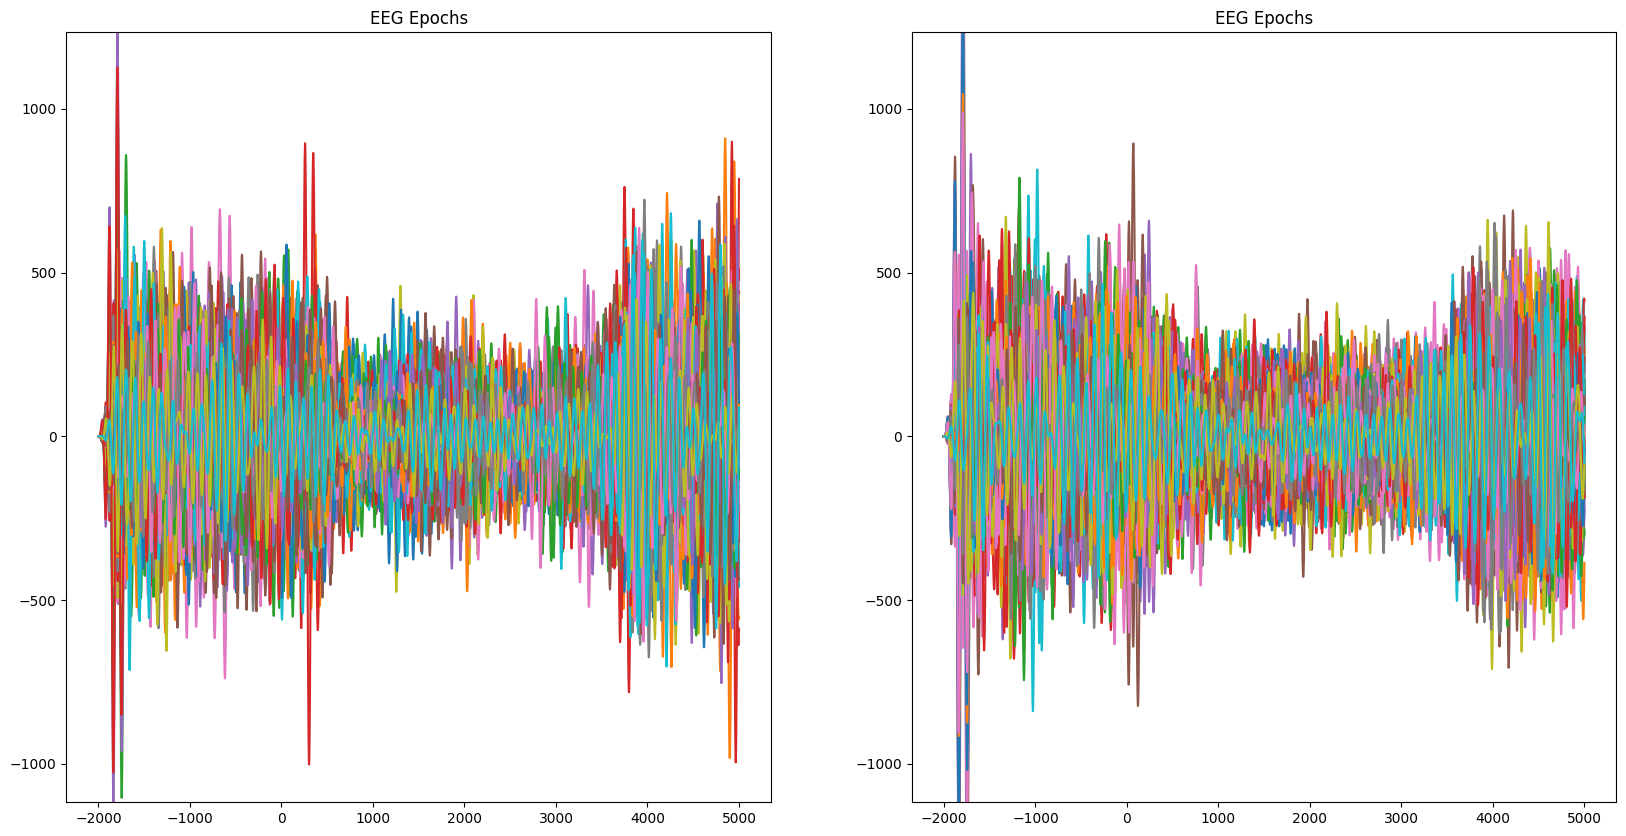

In [293]:
from scipy.signal import butter, lfilter

# Bandpass 필터 함수
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Bandpass 필터 적용
def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    filtered_data = np.zeros(data.shape)
    for trial in range(data.shape[0]):
        for channel in range(data.shape[1]):
            filtered_data[trial, channel, :] = butter_bandpass_filter(data[trial, channel, :], lowcut, highcut, fs, order)
    return filtered_data

# Bandpass 필터 적용 예제
lowcut = 8.0
highcut = 14.0
order = 5

filtered_RealMovement_left = apply_bandpass_filter(corrected_movement_left, lowcut, highcut, srate, order)
filtered_RealMovement_right = apply_bandpass_filter(corrected_movement_right, lowcut, highcut, srate, order)

filtered_MI_left = apply_bandpass_filter(corrected_MI_left, lowcut, highcut, srate, order)
filtered_MI_right = apply_bandpass_filter(corrected_MI_right, lowcut, highcut, srate, order)

draw_EEG_epochs(filtered_RealMovement_left, filtered_RealMovement_right, 0, is_mean=False)
draw_EEG_epochs(filtered_MI_left, filtered_MI_right, 0, is_mean=False)

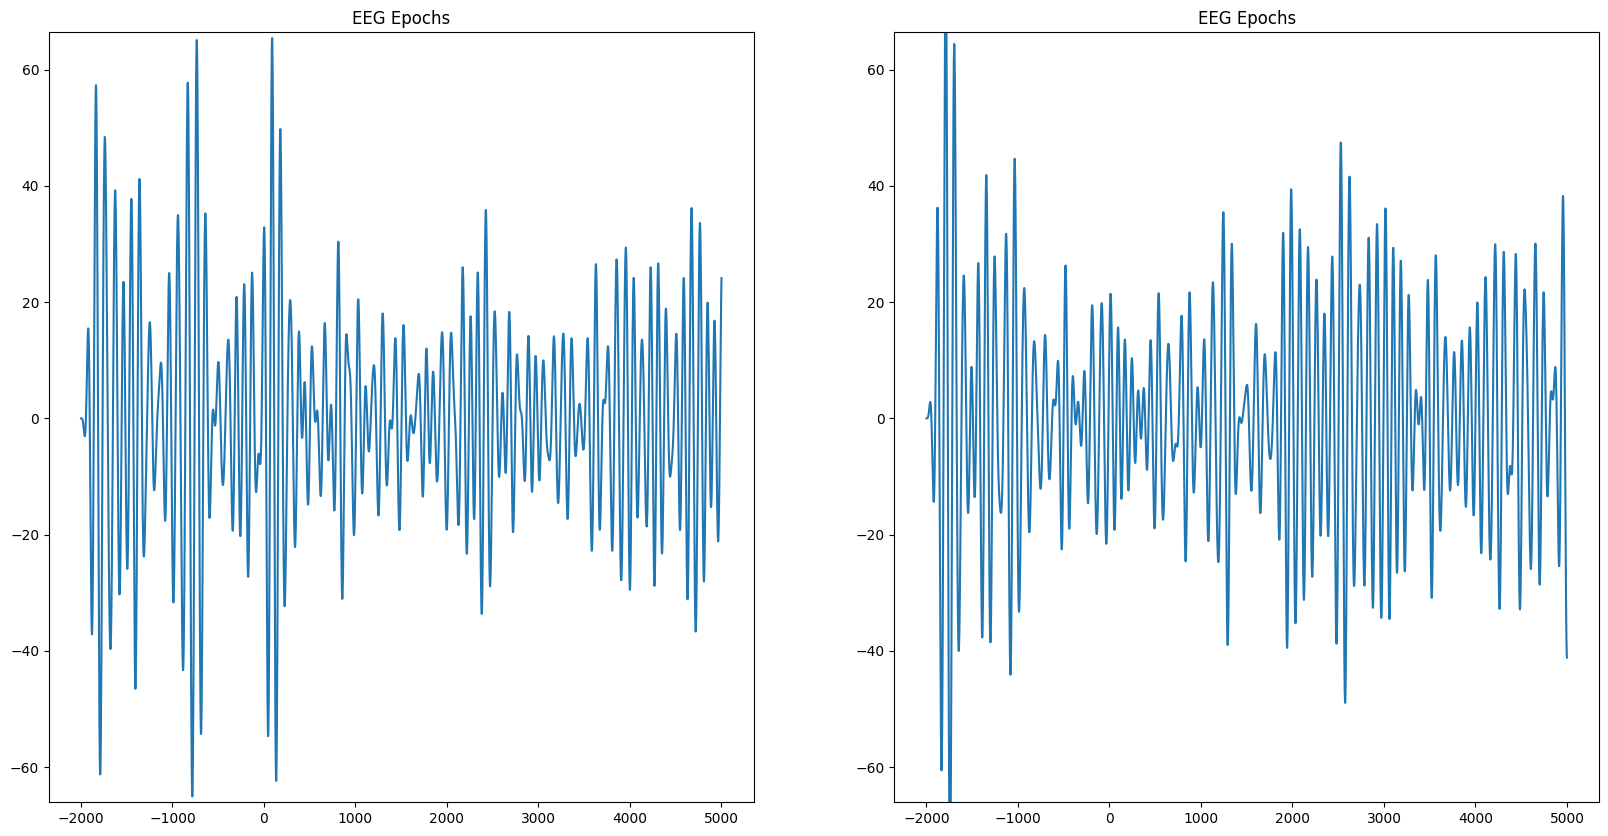

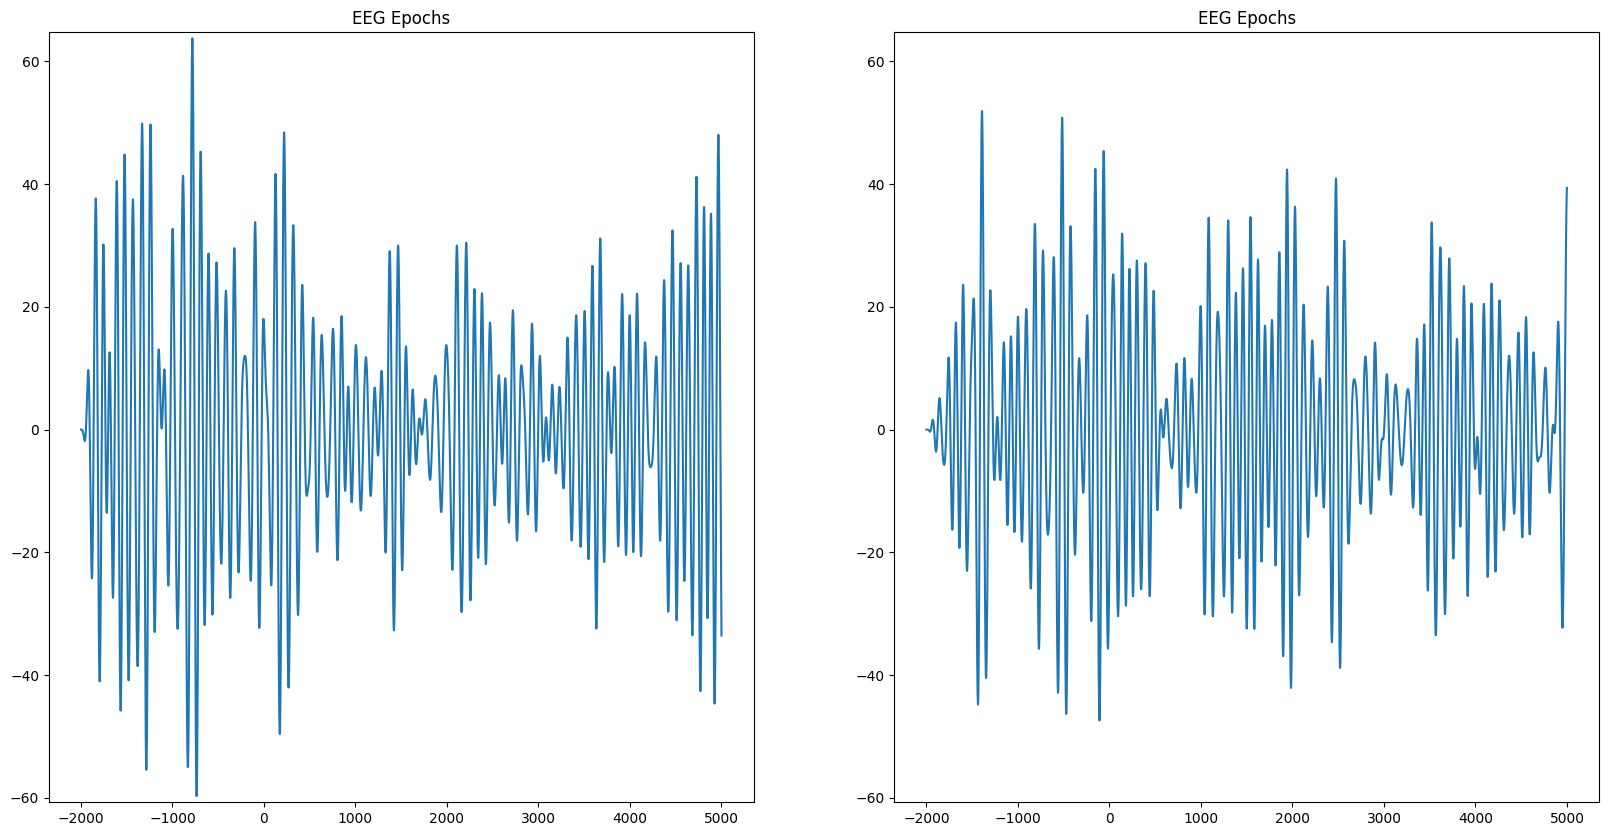

In [296]:
channel_list = [13, 50]
for i in channel_list:
# for i in range(64):
    draw_EEG_epochs(filtered_RealMovement_left, filtered_RealMovement_right, i, is_mean=True)
    # draw_EEG_epochs(filtered_MI_left, filtered_MI_right, i, is_mean=True)

모든 과정을 거친 후에, 우리가 원하는 뇌파가 되었는지 확인할 수 있습니다.

우리가 분류하고자 하는 데이터는 위 그림과 같습니다. 위 그림에서 Target은 300ms 부근에 peak가 있고, 아래 그림에서는 300ms 부근에 peak가 없습니다. 이처럼, 특정한 (의미있는) 자극이 주어졌을 때 300ms 부근에서 Peak가 발생하는 것을 P300 또는 P3라고 하며, 이것을 찾아내는 분류기를 만들어 볼 예정입니다.

**Downsampling**

머신러닝에 이용하기 위해 차원을 축소합니다. 여기서는 32 Channel x 32 time을 사용합니다.

In [261]:
resample_target_data = np.zeros(target_data.shape[:-1] + (32,))
resample_non_target_data = np.zeros(non_target_data.shape[:-1] + (32,))

tick = target_data.shape[-1] // 32
for i in range(32):
    tick_start, tick_end = i * tick, (i+1) * tick - 1 if i != 31 else target_data.shape[-1]
    resample_target_data[:, :, i] = np.mean(target_data[:, :, tick_start:tick_end], axis=2)

tick = non_target_data.shape[-1] // 32
for i in range(32):
    tick_start, tick_end = i * tick, (i+1) * tick - 1 if i != 31 else non_target_data.shape[-1]
    resample_non_target_data[:, :, i] = np.mean(non_target_data[:, :, tick_start:tick_end], axis=2)

NameError: name 'target_data' is not defined

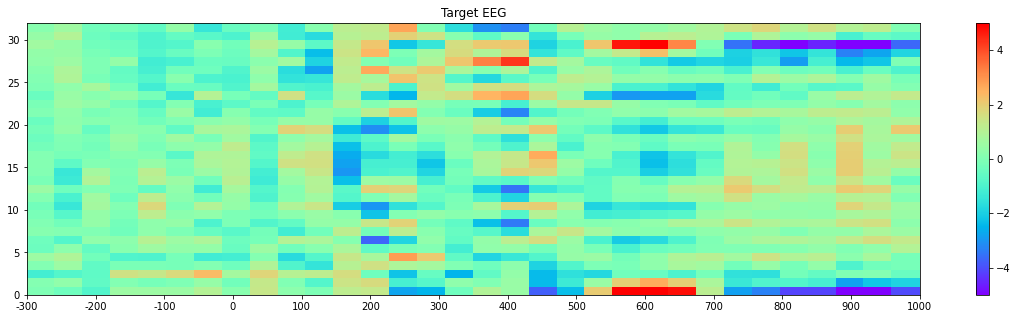

In [ ]:
draw_heatmap(np.mean(resample_target_data, axis=1), title='Target EEG')

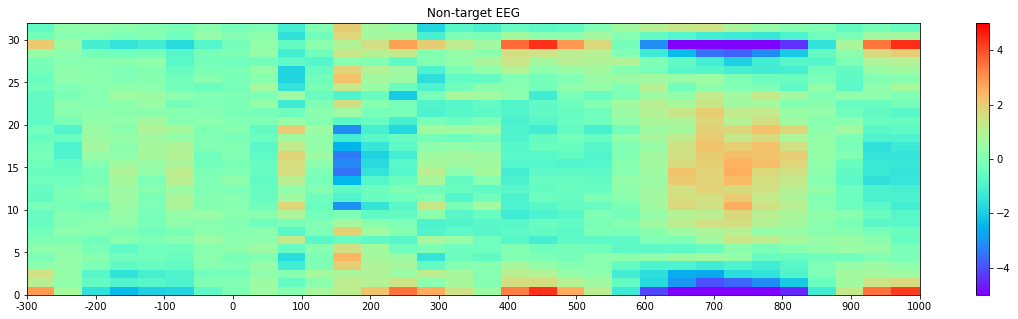

In [ ]:
draw_heatmap(np.mean(resample_non_target_data, axis=1), title='Non-target EEG')

## Save data

Downsampling한 데이터를 추후에 사용할 수 있도록 데이터를 저장합니다.

데이터가 (Channel, Time)으로 이루어져 있는데, 추후 학습에 쉽게 사용될 수 있도록 (Trial, Channel, Time)으로 변경하여 저장합니다.

In [ ]:
output_file = "./resampled_data.npz"
np.savez(output_file, target_data=resample_target_data, non_target_data=resample_non_target_data)